E:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

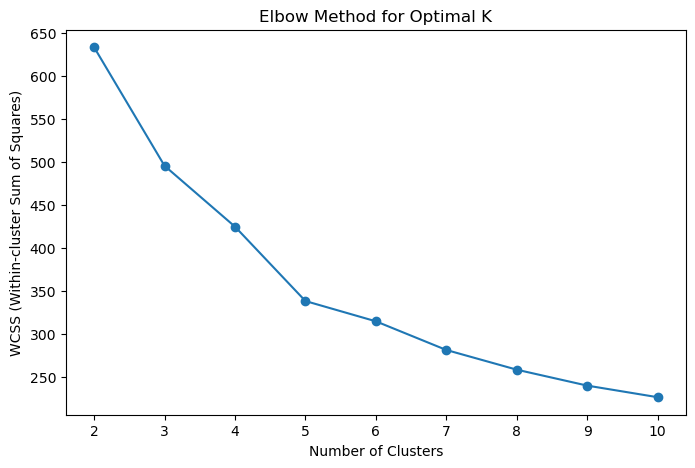

E:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 1.2238


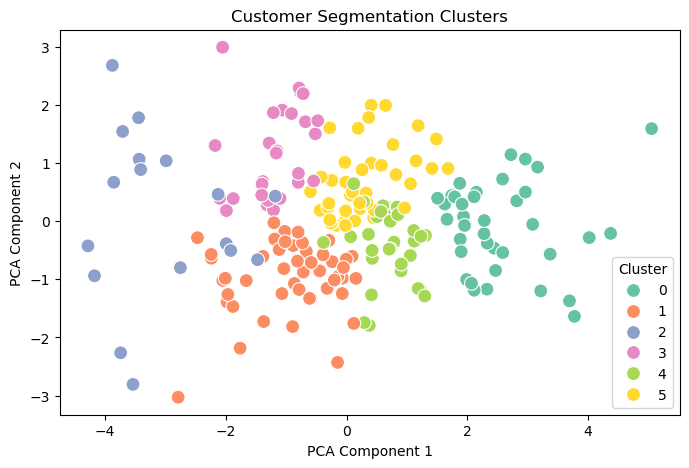

   Cluster   TotalValue   Quantity       Price  TransactionID     Recency
0        0  6127.848378  22.027027  280.611149       8.162162   75.540541
1        1  1995.199787   9.659574  210.105943       4.000000   81.744681
2        2  1070.562353   4.823529  227.525392       1.764706  279.764706
3        3  2466.809259   7.074074  348.250383       3.000000  114.259259
4        4  3933.082000  16.000000  245.386725       6.433333  119.166667
5        5  4065.729512  12.560976  321.686430       5.024390   92.829268


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

merged_df = pd.merge(transactions, customers, on="CustomerID", how="inner")

customer_data = merged_df.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "Price": "mean",
    "TransactionID": "nunique",
}).reset_index()

customer_data = pd.merge(customer_data, customers[["CustomerID", "Region", "SignupDate"]], on="CustomerID", how="left")

merged_df["TransactionDate"] = pd.to_datetime(merged_df["TransactionDate"])
last_transaction = merged_df.groupby("CustomerID")["TransactionDate"].max().reset_index()
last_transaction["Recency"] = (pd.to_datetime("today") - last_transaction["TransactionDate"]).dt.days
customer_data = pd.merge(customer_data, last_transaction[["CustomerID", "Recency"]], on="CustomerID", how="left")

X = customer_data[["TotalValue", "Quantity", "Price", "TransactionID", "Recency"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=40)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data["Cluster"] = kmeans.fit_predict(X_scaled)

db_index = davies_bouldin_score(X_scaled, customer_data["Cluster"])
print(f"Davies-Bouldin Index: {db_index:.4f}")

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
customer_data["PCA1"] = pca_result[:, 0]
customer_data["PCA2"] = pca_result[:, 1]

palette = sns.color_palette("Set2", n_colors=6)

plt.figure(figsize=(8, 5))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=customer_data, palette=palette, s=100)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Segmentation Clusters")
plt.legend(title="Cluster")
plt.show()

cluster_summary = customer_data.groupby("Cluster").agg({
    "TotalValue": "mean",
    "Quantity": "mean",
    "Price": "mean",
    "TransactionID": "mean",
    "Recency": "mean"
}).reset_index()

print(cluster_summary)
